In [1]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import tensorflow as tf

# Unet

In [2]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs, conv10)   

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

# Unet++

In [3]:
def unetpp(pretrained_weights = None,input_size = (256,256,3)):
    tf.keras.backend.clear_session()
    nb_filter = [64,128,256,512,1024]
    # Build U-Net++ model
    inputs = tf.keras.Input(shape=input_size)
#    s = Lambda(lambda x: x / 255) (inputs)


    c1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.2) (c1)
    c1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = Dropout(0.3) (c1)
    p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

    c2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.2) (c2)
    c2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = Dropout(0.2) (c2)
    p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
    conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = Dropout(0.1) (c3)

    conv3_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    conv3_1 = Dropout(0.1) (conv3_1)
    conv3_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
    conv3_1 = Dropout(0.2) (conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
    conv2_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
    conv2_2 = Dropout(0.2) (conv2_2)
    conv2_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
    conv2_2 = Dropout(0.3) (conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
    conv1_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
    conv1_3 = Dropout(0.2) (conv1_3)
    conv1_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
    conv1_3 = Dropout(0.2) (conv1_3)

    conv4_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
    conv4_1 = Dropout(0.3) (conv4_1)
    conv4_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
    conv4_1 = Dropout(0.2) (conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
    conv3_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
    conv3_2 = Dropout(0.2) (conv3_2)
    conv3_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
    conv3_2 = Dropout(0.2) (conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
    conv2_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
    conv2_3 = Dropout(0.3) (conv2_3)
    conv2_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
    conv2_3 = Dropout(0.3) (conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
    conv1_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
    conv1_4 = Dropout(0.1) (conv1_4)
    conv1_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
    conv1_4 = Dropout(0.2) (conv1_4)

    conv5_1 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
    conv5_1 = Dropout(0.2) (conv5_1)
    conv5_1 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
    conv5_1 = Dropout(0.2) (conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
    conv4_2 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
    conv4_2 = Dropout(0.2) (conv4_2)
    conv4_2 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
    conv4_2 = Dropout(0.2) (conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
    conv3_3 = Dropout(0.2) (conv3_3)
    conv3_3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
    conv3_3 = Dropout(0.2) (conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
    conv2_4 = Dropout(0.1) (conv2_4)
    conv2_4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
    conv2_4 = Dropout(0.3) (conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
    conv1_5 = Dropout(0.2) (conv1_5)
    conv1_5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
    conv1_5 = Dropout(0.3) (conv1_5)

    nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

    model = Model([inputs], [nestnet_output_4])

    return model

# 前置處理--訓練、驗證資料準備

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc
import cv2

def adjustData(img,mask):
    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

def trainGenerator(batch_size,
                   train_path,
                   image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "rgb", 
                   mask_color_mode = "grayscale",
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir =None,
                   target_size = (256,256),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

def ValGenerator(batch_size,
                 val_path,
                 image_folder,
                 mask_folder,
                 num_class = 2,
                 save_to_dir =None,
                 target_size = (256,256),
                 seed = 1):
  
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        val_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        val_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    val_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in val_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

def testGenerator(test_path,
                  num_image=30,
                  target_size = (256,256),
                  as_gray = False):

    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = cv2.imread(os.path.join(test_path,files[i]))
        print(files[i])
        img = trans.resize(img,target_size)
        img=img.astype(np.float32)
        img=np.expand_dims(img, axis=0)
        yield img
        
        
def testGenerators(test_path,
                 image_folder,
                 num_class = 2,
                 target_size = (256,256),
                 seed = 1):
    
    image_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        test_path,
        classes = [image_folder],
        color_mode = 'rgb',
        target_size = target_size,
        seed = seed)  
    
    mask_generator = mask_datagen.flow_from_directory(
        test_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        seed = seed)

    
    test_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in test_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

# 視覺化圖形並儲存圖片之函數

In [5]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]    
    return img_out

def saveResult(img_path,save_path,npyfile,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    files = sorted(files)
    print(len(img_path))
    print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)

# 績效指標函數

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-5) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-5)

def Jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def convert_unit(error_pixels, original_image_size, resized_image_size):
    cm_per_pixel = 1 / 72
    resized_cm_per_pixel = (original_image_size / resized_image_size) * cm_per_pixel
    error_cm = error_pixels * resized_cm_per_pixel
    return error_cm

def mec(y_test, preds, original_size):

    gt = cv2.normalize(y_test[0], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    gt = gt.astype(np.uint8)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    
    pred = cv2.normalize(preds[0].numpy(), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    pred = pred.astype(np.uint8)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    
    error_cm = 0
    error_half = 0
    num_error_one = 0
    
    contours, _ = cv2.findContours(gt, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_gt = tuple(max_contour[max_contour[:,:,1].argmax()][0])

    contours, _ = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_pred = tuple(max_contour[max_contour[:,:,1].argmax()][0])

    error_pixels = np.abs(bottom_point_gt[1] - bottom_point_pred[1])

    error_cm = convert_unit(error_pixels, original_size, 256)

    if error_cm <= 0.5:
        error_half = 100
    else:
        error_half =100-error_pixels

    if error_cm <= 1:
        error_one = 100
    else:
        error_one =100-error_pixels
    
    return error_cm, error_half, error_one

# 資料增強函數及路徑設定

In [62]:
data_gen_args = dict(rotation_range=0.3,
                    width_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')

PATH='./Fold5/'
PATH

'./Fold5/'

In [63]:
if not os.path.exists(PATH+'predunetpp'):
    os.makedirs(PATH+'predunetpp') 

data_gen = trainGenerator(batch_size=5,
                          train_path=PATH,
                          image_folder='train',
                          mask_folder='trainannot',
                          aug_dict=data_gen_args, )

val_gen = ValGenerator(batch_size=5,
                       val_path=PATH,
                       image_folder='val', 
                       mask_folder='valannot',
                       target_size = (256,256),
                       seed = 1)

# 訓練

In [9]:
model = unet()
#model = unetpp()
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = [Jaccard_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  4719104     ['concatenate[0][0]']            
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 512)  2359808     ['conv2d_11[0][0]']              
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 64, 64, 512)  0          ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 256)  524544      ['up_sampling2d_1[0][0]']        
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64, 512)  0           ['batch_normalization_5[0][0]',  
          

# 超參數設定和開始訓練

In [16]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet1.hdf5', 
                                                      monitor='val_Jaccard_coef',
                                                      verbose=1, 
                                                      save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_Jaccard_coef',
                              factor=0.5,
                              patience=20,
                              verbose=1,
                              mode='max',
                              min_lr=0.000001)

early_stopping = EarlyStopping(monitor='val_Jaccard_coef',
                               patience=20,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)

history=model.fit(data_gen,
          steps_per_epoch=400,
          epochs=200,
          verbose=1,
          validation_data= val_gen,
          validation_steps=30,
          callbacks=[model_checkpoint,reduce_lr,early_stopping])

Found 285 images belonging to 1 classes.
Found 285 images belonging to 1 classes.
Epoch 1/200
400/400 [==============================] - ETA: 0s - loss: 0.0317 - Jaccard_coef: 0.2002Found 48 images belonging to 1 classes.
Found 48 images belonging to 1 classes.

Epoch 1: val_Jaccard_coef improved from -inf to 0.23321, saving model to unet5.hdf5
400/400 [==============================] - 111s 269ms/step - loss: 0.0317 - Jaccard_coef: 0.2002 - val_loss: 0.0146 - val_Jaccard_coef: 0.2332 - lr: 1.0000e-04
Epoch 2/200
400/400 [==============================] - ETA: 0s - loss: 0.0155 - Jaccard_coef: 0.3177
Epoch 2: val_Jaccard_coef improved from 0.23321 to 0.23981, saving model to unet5.hdf5
400/400 [==============================] - 106s 266ms/step - loss: 0.0155 - Jaccard_coef: 0.3177 - val_loss: 0.0150 - val_Jaccard_coef: 0.2398 - lr: 1.0000e-04
Epoch 3/200
400/400 [==============================] - ETA: 0s - loss: 0.0138 - Jaccard_coef: 0.3503
Epoch 3: val_Jaccard_coef improved from 0.23

Epoch 25/200
400/400 [==============================] - ETA: 0s - loss: 0.0028 - Jaccard_coef: 0.8564
Epoch 25: val_Jaccard_coef did not improve from 0.72620
400/400 [==============================] - 106s 266ms/step - loss: 0.0028 - Jaccard_coef: 0.8564 - val_loss: 0.0078 - val_Jaccard_coef: 0.7142 - lr: 1.0000e-04
Epoch 26/200
400/400 [==============================] - ETA: 0s - loss: 0.0028 - Jaccard_coef: 0.8571
Epoch 26: val_Jaccard_coef did not improve from 0.72620
400/400 [==============================] - 106s 265ms/step - loss: 0.0028 - Jaccard_coef: 0.8571 - val_loss: 0.0106 - val_Jaccard_coef: 0.5801 - lr: 1.0000e-04
Epoch 27/200
400/400 [==============================] - ETA: 0s - loss: 0.0032 - Jaccard_coef: 0.8411
Epoch 27: val_Jaccard_coef improved from 0.72620 to 0.73606, saving model to unet5.hdf5
400/400 [==============================] - 107s 267ms/step - loss: 0.0032 - Jaccard_coef: 0.8411 - val_loss: 0.0076 - val_Jaccard_coef: 0.7361 - lr: 1.0000e-04
Epoch 28/200
4

Epoch 76/200
400/400 [==============================] - ETA: 0s - loss: 0.0012 - Jaccard_coef: 0.9347
Epoch 76: val_Jaccard_coef did not improve from 0.78575
400/400 [==============================] - 106s 265ms/step - loss: 0.0012 - Jaccard_coef: 0.9347 - val_loss: 0.0097 - val_Jaccard_coef: 0.7622 - lr: 1.0000e-04
Epoch 77/200
400/400 [==============================] - ETA: 0s - loss: 0.0012 - Jaccard_coef: 0.9347
Epoch 77: val_Jaccard_coef did not improve from 0.78575
400/400 [==============================] - 106s 265ms/step - loss: 0.0012 - Jaccard_coef: 0.9347 - val_loss: 0.0109 - val_Jaccard_coef: 0.7398 - lr: 1.0000e-04
Epoch 78/200
400/400 [==============================] - ETA: 0s - loss: 0.0013 - Jaccard_coef: 0.9309
Epoch 78: val_Jaccard_coef did not improve from 0.78575
400/400 [==============================] - 106s 265ms/step - loss: 0.0013 - Jaccard_coef: 0.9309 - val_loss: 0.0081 - val_Jaccard_coef: 0.7853 - lr: 1.0000e-04
Epoch 79/200
400/400 [========================

# 儲存預測結果

In [64]:
model = tf.keras.models.load_model('unetpp5.hdf5', custom_objects={"Jaccard_coef": Jaccard_coef})
model.load_weights("unetpp5.hdf5")
n_i=len(os.listdir('./Fold5/test/'))
test_gen = testGenerator('./Fold5/test/')
results = model.predict_generator(test_gen,n_i,verbose=1)
saveResult('./Fold5/test/','./Fold5/predunetpp/',results)

C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\4097923090.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_gen,n_i,verbose=1)


A000100.jpg
48/48 [==============================] - 38s 802ms/step


C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\2543975658.py:16: UserWarning: ./Fold5/predunetpp/A000100.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\2543975658.py:16: UserWarning: ./Fold5/predunetpp/A000110.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\2543975658.py:16: UserWarning: ./Fold5/predunetpp/A000120.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy c

13
48


C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\2543975658.py:16: UserWarning: ./Fold5/predunetpp/a0_125.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\2543975658.py:16: UserWarning: ./Fold5/predunetpp/a0_127.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Chen\AppData\Local\Temp\ipykernel_9720\2543975658.py:16: UserWarning: ./Fold5/predunetpp/a0_1

# 計算績效

In [65]:
import glob
CurrentDirectory=os.getcwd()
testImagePath =CurrentDirectory+"/Fold5/test/"
imagePath = glob.glob(testImagePath+"*.jpg")
imagePath.sort()
print(len(imagePath))

GTPath= CurrentDirectory+"/Fold5/testannot/"
GT = glob.glob(GTPath+"*.png")
GT.sort()
print(len(GT))

48
48


In [66]:
Dice=[]
IoU=[]
MEC=[]
MECh=[]
MECo=[]

for imageName,gtName in zip(imagePath,GT):
    img0 = cv2.imread(imageName)
    osize=img0.shape[0]
    img0 = trans.resize(img0,(256,256))
    rsize=img0.shape[0]
    img0=np.expand_dims(img0, axis=0)
    img2=model.predict(img0)
    img2 = tf.tile(img2, [1, 1, 1, 3])
    
    img1 = cv2.imread(gtName)
    img1 = trans.resize(img1,(256,256))
    img1=img1.astype(np.float32)
    img1=np.expand_dims(img1, axis=0)
    
    
    mecs=mec(img1, img2, osize)
    MEC.append(mecs[0])
    MECh.append(mecs[1])
    MECo.append(mecs[2])
    dices=dice_coef(img1, img2)
    Dice.append(dices.numpy())
    ious=Jaccard_coef(img1, img2)
    IoU.append(ious.numpy())
#print(Dice)
#print(IoU)
#print(MEC)
#print(MECh)
#print(MECo)
print('Dice Loss:', 1-(sum(Dice) / len(Dice)))
print('IoU:',  sum(IoU) / len(IoU))
print('平均誤差公分:',  sum(MEC) / len(MEC))
print('誤差在0.5公分內準確率:',  sum(MECh) / len(MECh))
print('誤差在1公分內準確率:',  sum(MECo) / len(MECo))

1/1 [==============================] - 0s 16ms/step
Dice Loss: 0.1864170810828606
IoU: 0.70921714999713
平均誤差公分: 1.313928674768518
誤差在0.5公分內準確率: 92.33333333333333
誤差在1公分內準確率: 93.22916666666667


# 視覺化

In [ ]:
PredPath= CurrentDirectory+"/Fold5/predunet/"
Pred = glob.glob(PredPath+"*.png")
Pred.sort()
print(len(Pred))


for imageName,gtName,predName in zip(imagePath,GT,Pred):
    img0 = cv2.imread(imageName)
    img0 = trans.resize(img0,(256,256))
#    img0=np.expand_dims(img0, axis=0)
    img1 = cv2.imread(gtName)
    img1 = trans.resize(img1,(256,256))
#    img1=np.expand_dims(img1, axis=0)
    img2 = cv2.imread(predName)


Text(0.5, 1.0, 'Segmentation Prediction')

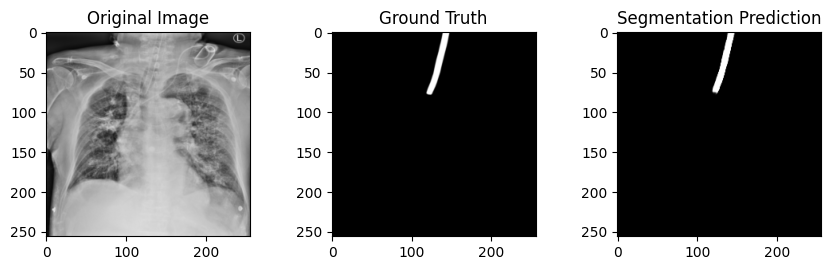

In [74]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(img0)
ax.set_title("Original Image")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img1, cmap="gray")
ax.set_title("Ground Truth") 

ax = fig.add_subplot(1, 3, 3)
ax.imshow(img2, cmap="gray")
ax.set_title("Segmentation Prediction") 